# TFG Migración y turismo inteligente.

Modelos de IA para análisis y visualización. 

# Modelos Clustering

## 0. Resumen ejecutivo

En este notebook se analizan diferentes modelos de **clustering** aplicados a datos de turismo, con el objetivo de identificar **segmentos de mercado** (perfiles de turistas) que puedan explotarse posteriormente en el dashboard de **Power BI** junto con las predicciones de demanda.

El punto de partida es un conjunto de datos ya preprocesado (`clustering_preprocesado.pkl`), donde cada fila representa una combinación de **comunidad autónoma de destino**, **país de residencia** y características del viaje. Las variables incluyen:

- Variables categóricas codificadas (one-hot) relacionadas con:
  - Comunidad autónoma de destino.
  - País de residencia.
  - Tipo de alojamiento.
  - Forma de organización del viaje.
  - Vía de acceso.
- Variables numéricas derivadas, como el volumen de viajeros (por ejemplo, `Total_log`), previamente transformadas y escaladas.

Sobre estos datos se van a evaluar tres enfoques de clustering:

1. **K-Means** (baseline clásico): Se exploran distintos valores de *k* y se selecciona el número de clusters en función de métricas internas.
2. **HDBSCAN**: basado en densidad, capaz de detectar clusters de tamaño y forma arbitraria y de marcar ruido.
3. **Gaussian Mixture Models (GMM)**: Modelo probabilístico que asume mezclas de distribuciones normales y permite asignar probabilidades de pertenencia a cada cluster.

La calidad de las particiones se evalúa mediante métricas internas estándar:

- **Silhouette score** (a mayor, mejor separación entre clusters).
- **Davies–Bouldin index** (a menor, mejor separación y compacidad).
    - En el caso de GMM, también se utiliza el **Bayesian Information Criterion (BIC)** para comparar configuraciones con distinto número de clusters.

Los resultados muestran que:

- **HDBSCAN** obtiene las mejores métricas, pero genera demasiados de clusters (75), lo que dificulta su interpretación y uso práctico en cuadros de mando.
- **K-Means** produce un número manejable de clusters (8), pero con métricas internas más débiles y demasiada rigidez.
- **GMM** supone un **compromiso razonable**: mejora a K-Means en métricas, mantiene un número de clusters manejable (12) y los segmentos interpretables desde el punto de vista de negocio (combinaciones de región y mercado de origen).

Por ello, el modelo elegido para el TFG es **GMM con un número moderado de clusters**. A partir de esa solución se construyen tablas de salida (clusters asignados, agregaciones por comunidad y país, y una tabla de perfiles de cluster) que se utilizarán como **fuente de datos para Power BI**, permitiendo analizar:

- Qué países se agrupan con qué comunidades autónomas.
- Qué tipos de viajes (duración, alojamiento, organización) caracterizan a cada segmento.
- Cómo se relacionan estos segmentos con las predicciones de demanda obtenidas en el notebook de forecasting.

## 1. Carga de datos y preparación inicial

El dataset utilizado en este notebook procede del preprocesado realizado en un notebook anterior y se guarda en un fichero `clustering_preprocesado.pkl` mediante `joblib`. Este fichero contiene varios dataframes intermedios:

- `df_prep`: datos originales ya limpios y enriquecidos (antes de codificar).
- `df_cluster_ready`: dataset listo para el clustering (variables seleccionadas y codificadas).
- `df_scaled`: versión escalada para aplicar PCA y algunos modelos.
- `pca_df`: representación en componentes principales para visualización y apoyo al modelado.

En este notebook:

- Usaremos **`df_cluster_ready`** como base para entrenar los modelos de clustering.
- `df_scaled` y `pca_df` se usarará para el análisis de los modelos.
- `df_prep` para la interpretación de los clusters (recuperar nombres de comunidad, país, etc.).

También se carga el csv creado en el notebook anterior por trazabilidad.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import hdbscan
import joblib

In [2]:
# Carga de datos del anterior notebook.
data = joblib.load("clustering_preprocesado.pkl")
df_cluster_ready = data["df_cluster_ready"]
df_scaled = data["df_scaled"]
pca_df = data["pca_df"]
df_prep = data["df_prep"]

In [3]:
print(f"Dimensión del dataset de clustering: {df_cluster_ready.shape[0]} filas x {df_cluster_ready.shape[1]} columnas")
df_cluster_ready.head()

Dimensión del dataset de clustering: 15013 filas x 34 columnas


,Comunidad autónoma de destino_01 Andalucía,"Comunidad autónoma de destino_04 Balears, Illes",Comunidad autónoma de destino_05 Canarias,Comunidad autónoma de destino_09 Cataluña,Comunidad autónoma de destino_10 Comunitat Valenciana,"Comunidad autónoma de destino_13 Madrid, Comunidad de",Comunidad autónoma de destino_Otras,País de residencia_Alemania,País de residencia_Bélgica,País de residencia_Dinamarca,...,Tipo de alojamiento_De mercado,Tipo de alojamiento_Hotelero,Tipo de alojamiento_Resto de mercado,Tipo de alojamiento_Vivienda de familiares o amigos,Tipo de alojamiento_Vivienda en alquiler,Tipo de alojamiento_Vivienda en propiedad,Forma de organización del viaje_Con paquete turístico,Forma de organización del viaje_Sin paquete turístico,Duración codificada,Total_log
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,9.144201
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,9.671555
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,9.956934
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,8.880586
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,9.144201


In [4]:
ruta_csv_clustering = "df_clustering.csv"

df_clustering_csv = pd.read_csv(ruta_csv_clustering, encoding="utf-8-sig")
print(f"Dimensión del dataset de clustering: {df_clustering_csv.shape[0]} filas x {df_clustering_csv.shape[1]} columnas")

Dimensión del dataset de clustering: 15013 filas x 34 columnas


## 2. Modelos de clustering: definición e implementación

### 2.1. Clustering con K-Means

K-Means se utiliza en este trabajo como **modelo base** por varios motivos:

- Es uno de los algoritmos de clustering más extendidos y se ha utilizado de forma recurrente en el grado.
- Permite obtener una partición sencilla de interpretar (clusters esféricos en el espacio).
- Sirve como **punto de comparación** frente a modelos más flexibles como HDBSCAN o GMM.

El modelo trabaja sobre el dataset escalado (`df_scaled`), de forma que todas las variables numéricas y codificadas tengan un peso comparable.  
Para elegir el número de clusters \(K\), se exploran distintas particiones y se calculan métricas internas:

- **Elbow / Inertia**: ayuda a ver a partir de qué K la ganancia marginal de compactación deja de ser relevante.
- **Silhouette score**: mide la separación entre clusters (a mayor valor, mejor).
- **Davies–Bouldin index**: (solo para el K seleccionado) mide la separación y compacidad (a menor valor, mejor).

En este dataset, los valores de silueta son relativamente bajos (≈0.10-0.14), lo que ya adelanta que K-Means no consigue separaciones muy nítidas entre grupos. Esto refuerza la idea de usar K-Means como **baseline** y apoyarse después en modelos como GMM para obtener segmentos más consistentes.

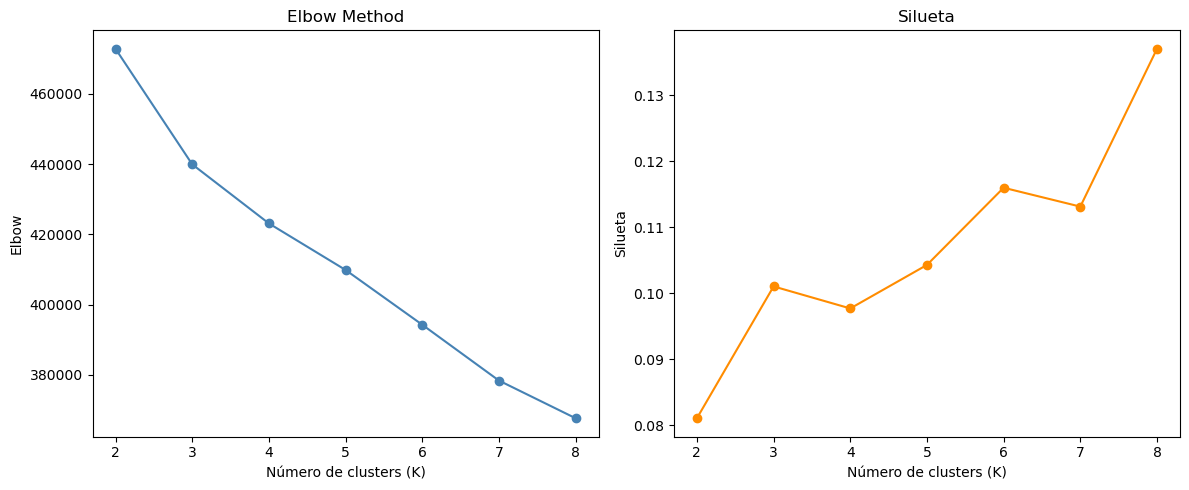

Número óptimo según silueta: 8
Silueta final (K-Means): 0.137
Davies–Bouldin (K-Means): 2.006


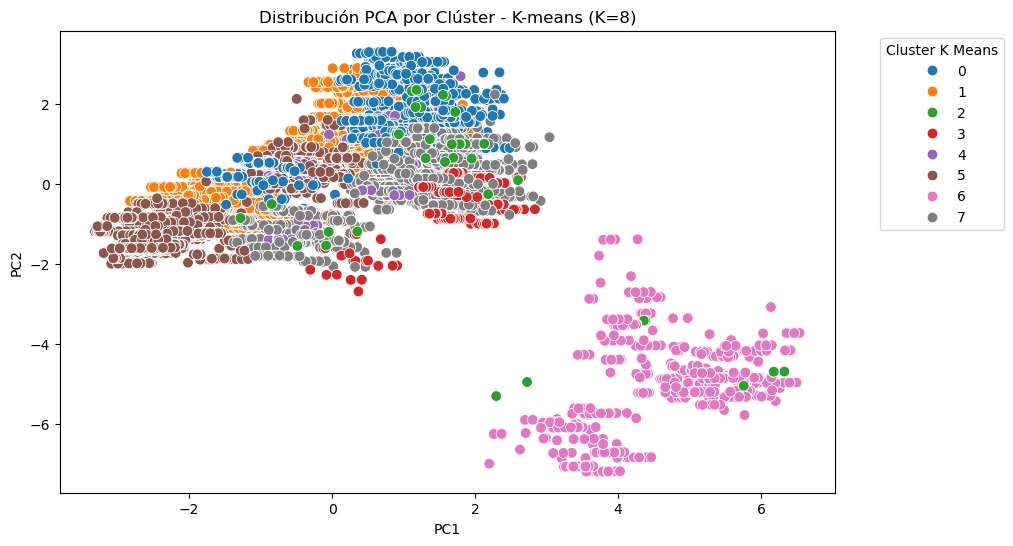

In [5]:
# Busqueda de número óptimo de clusters (KMeans)
elbow = []
silhouette_vals = []

K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    elbow.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(df_scaled, labels))

fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

ax1[0].plot(K_range, elbow, 'o-', color='steelblue')
ax1[0].set_title("Elbow Method")
ax1[0].set_xlabel("Número de clusters (K)")
ax1[0].set_ylabel("Elbow")

ax1[1].plot(K_range, silhouette_vals, 'o-', color='darkorange')
ax1[1].set_title("Silueta")
ax1[1].set_xlabel("Número de clusters (K)")
ax1[1].set_ylabel("Silueta")

plt.tight_layout()
plt.show()

# Seleccionar el mejor K por silhouette
k_optimo = K_range[np.argmax(silhouette_vals)]
print(f"Número óptimo según silueta: {k_optimo}")

# Entrenamiento
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(df_scaled)

# Evaluación
silhouette_avg = silhouette_score(df_scaled, labels_final)
db_score = davies_bouldin_score(df_scaled, labels_final)
print(f"Silueta final (K-Means): {silhouette_avg:.3f}")
print(f"Davies–Bouldin (K-Means): {db_score:.3f}")

# PCA con colores por cluster
pca_df['Cluster_KMeans'] = labels_final
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_KMeans', palette='tab10', s=60)
plt.title(f"Distribución PCA por Clúster - K-means (K={k_optimo})")
plt.legend(title="Cluster K Means", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

df_cluster_ready['Cluster_KMeans'] = labels_final

Conforme a los resultados de K-Means, el numero de clusters óptimo se estima en 8. 

El método del codo no muestra un punto de inflexión claro, sin embargo la silueta y Davis-Boudin si mejoran al subir a 8 clusters (mejor silueta y menor Davies-Bouldin).

La métrica de la silueta es baja (0.137) lo que indica solapamiento entre grupos (aunque es normal puesto que hablamos de turistas y es un tipo de comportamiento compartido).

No obstante, hay que tener en cuenta que K-Means genera grupos basados en círculos/esferas a partir de centroides y asigna cada observación al centro mas cercano. Los cluster se generan por la cercania de los puntos a los centroides y la separacion entre centroides. Esto puede generar agrupaciones muy forzadas en algunos puntos (sobre todo los limite o frontera entre clústeres).

La representación de las dos componentes principales representa dos nubes de puntos bien diferenciadas. 

* La dispersión horizontal (PC1) puede indicar diferencias en volumen de viajeros, tipo de alojamiento o paquete turístico.
* La dispersión vertical (PC2) indica diferencias en el tipo de comunidad o país.

Aun así, se muestra una densidad alta de puntos en cada una de las regiones.

En conjunto, los resultados indican que K-Means ofrece una partición inicial útil como **modelo de referencia**, pero con clústeres parcialmente solapados que justifican explorar otros modelos.

### 2.2 Clustering con HDBSCAN

Dada la alta densidad y el solapamiento entre puntos observados en K-Means, se aplica a continuación **HDBSCAN** como modelo de clustering basado en densidad.  
Este algoritmo es una extensión jerárquica de DBSCAN, más robusta frente a densidades heterogéneas y permite:

- Detectar automáticamente el número de clústeres (no requiere fijar K).
- Identificar observaciones como ruido (`label = -1`).
- Capturar clústeres con formas no esféricas, evitando una de las principales limitaciones de K-Means.

En este trabajo se fijan los parámetros principales en:

- `min_cluster_size = 100`: tamaño mínimo de clúster para que el grupo resulte **estable e interpretable** en términos de política turística; valores más bajos producen muchos micro-clústeres poco útiles.
- `min_samples = 10`: controla la sensibilidad al ruido. Con este valor se elimina ruido espurio sin “vaciar” clústeres relevantes.

Clusters detectados: 76
Ruido: 988
Silueta final (HDBSCAN): 0.449
Davies–Bouldin (HDBSCAN): 0.909


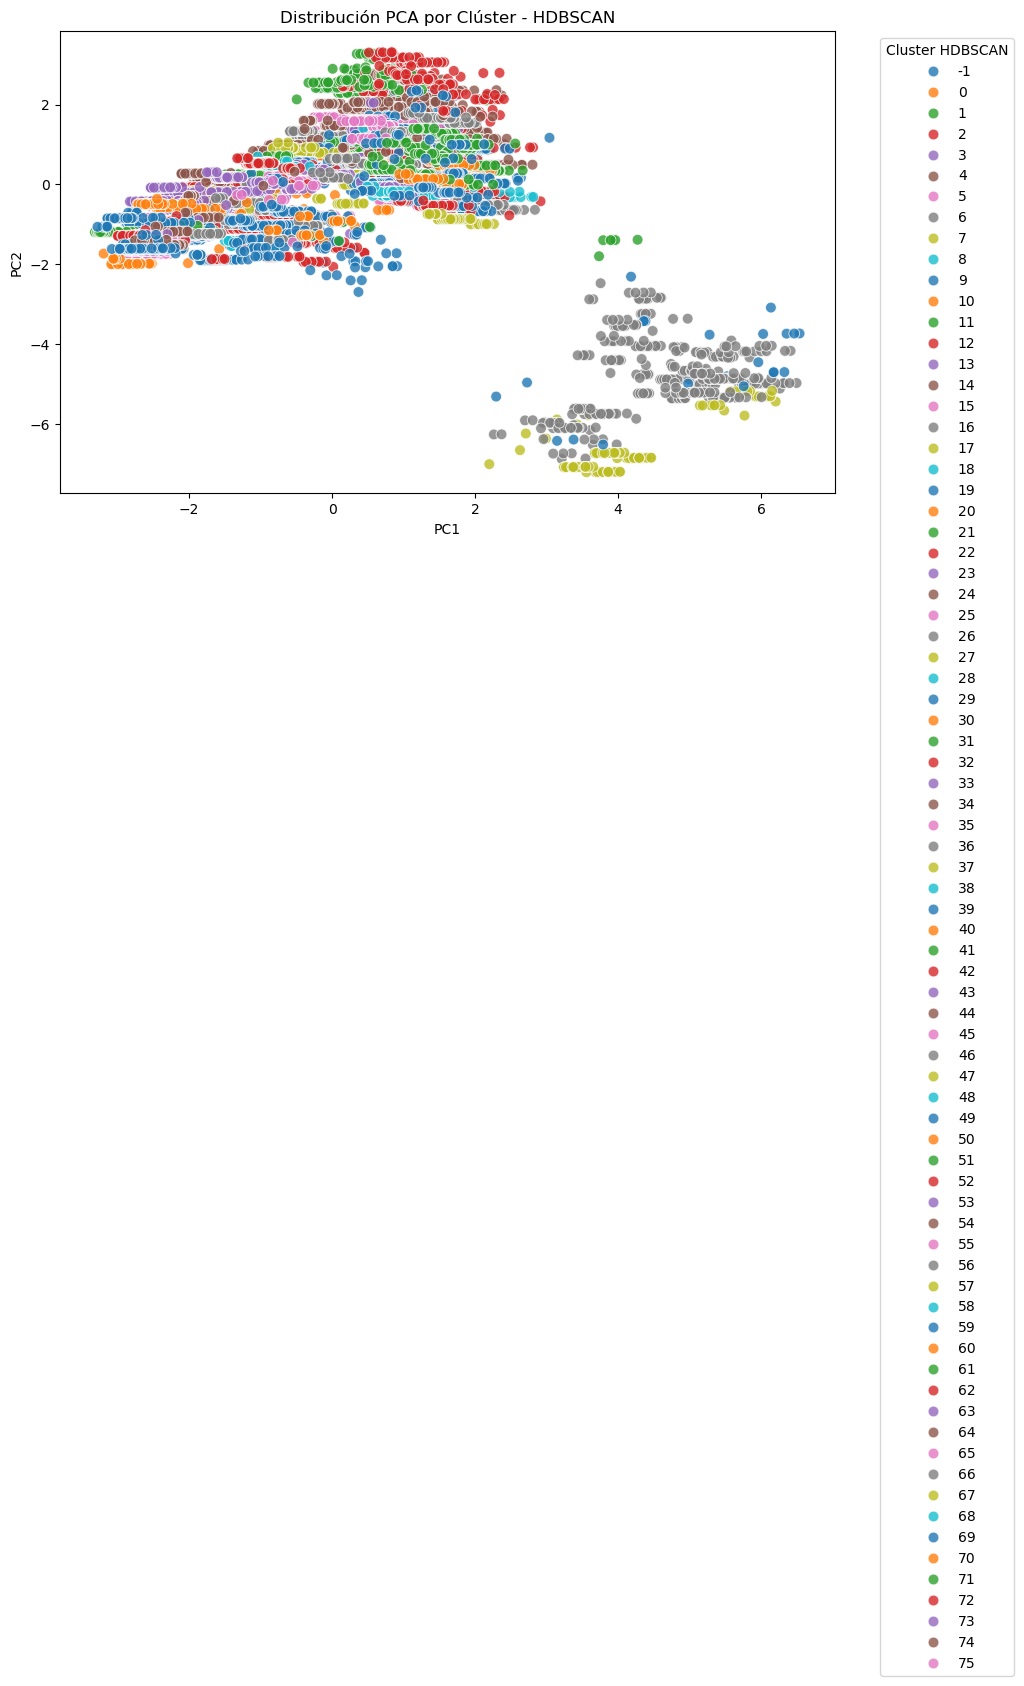

In [6]:
# min_cluster_size define el tamaño mínimo de un clúster
# min_samples controla la sensibilidad al ruido
hdbs = hdbscan.HDBSCAN( min_cluster_size=100, min_samples=10, metric='euclidean')

# Entrenamiento
labels_hdb = hdbs.fit_predict(df_scaled)
n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
n_noise = list(labels_hdb).count(-1)

print(f"Clusters detectados: {n_clusters}")
print(f"Ruido: {n_noise}")

# Evaluación
mask_valid = labels_hdb != -1
sil_hdb = silhouette_score(df_scaled[mask_valid], labels_hdb[mask_valid])
db_hdb = davies_bouldin_score(df_scaled[mask_valid], labels_hdb[mask_valid])
print(f"Silueta final (HDBSCAN): {sil_hdb:.3f}")
print(f"Davies–Bouldin (HDBSCAN): {db_hdb:.3f}")

# PCA con colores por cluster
pca_df['Cluster_HDBSCAN'] = labels_hdb
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_HDBSCAN', palette='tab10', s=60, alpha=0.8)
plt.title("Distribución PCA por Clúster - HDBSCAN")
plt.legend(title="Cluster HDBSCAN", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

df_cluster_ready['Cluster_HDBSCAN'] = labels_hdb

Los resultados obtenidos son:

- **76 clústeres detectados** y **988 observaciones** clasificadas como ruido.
- **Silueta (HDBSCAN) = 0.449**, frente a 0.137 en K-Means.
- **Davies–Bouldin (HDBSCAN) = 0.909**, frente a 2.006 en K-Means.

La silueta se calcula sobre las observaciones asignadas a algún clúster mejorando las metricas de K-Means lo que indica que los grupos son más compactos y mejor separados.  

El descenso del índice de Davies–Bouldin indica menor solapamiento entre clústeres.

Sin embargo, se han generado un **número muy elevado de clústeres (76)**, lo que dificulta su uso directo como herramienta de toma de decisiones para gestores turísticos. Por tanto se descarta como modelo para Power BI, pero si es indicativo de que existen patrones de densidad más complejos que los capturados por K-Means.

Por otro lado, se considera adecuado probar modelos probabilísticos como **GMM**, que permiten obtener un número reducido de segmentos manteniendo una separación razonable entre perfiles.

### 2.3 Clustering con GMM

Tras los resultados anteriores se evalua un modelo de **mezclas gaussianas (GMM)**:

- comparte con K-Means la idea de agrupar en torno a centros,
- pero permite **clústeres elípticos y probabilísticos**, en vez de esferas rígidas alrededor del centroide.

Dada la forma alargada de las nubes de puntos en el espacio PCA y el elevado número de clústeres detectados por HDBSCAN, GMM podría ser más flexible que K-Means, pero tambien más interpretable y con un número de grupos controlable.

**Configuración del modelo**

1. Para reducir la dimensionalidad previa (muchas variables tras el one-hot encoding), se entrena GMM sobre las **10 primeras componentes principales**  que concentran la mayor parte de la varianza y estabilizan el ajuste.
2. Se prueba un rango de componentes de K entre 2 y 13.
3. Para cada K se calculan:
   - **BIC** (Bayesian Information Criterion), donde valores más bajos indican mejor relación entre ajuste y complejidad;
   - **Silhouette score**, como medida adicional de separación entre grupos.

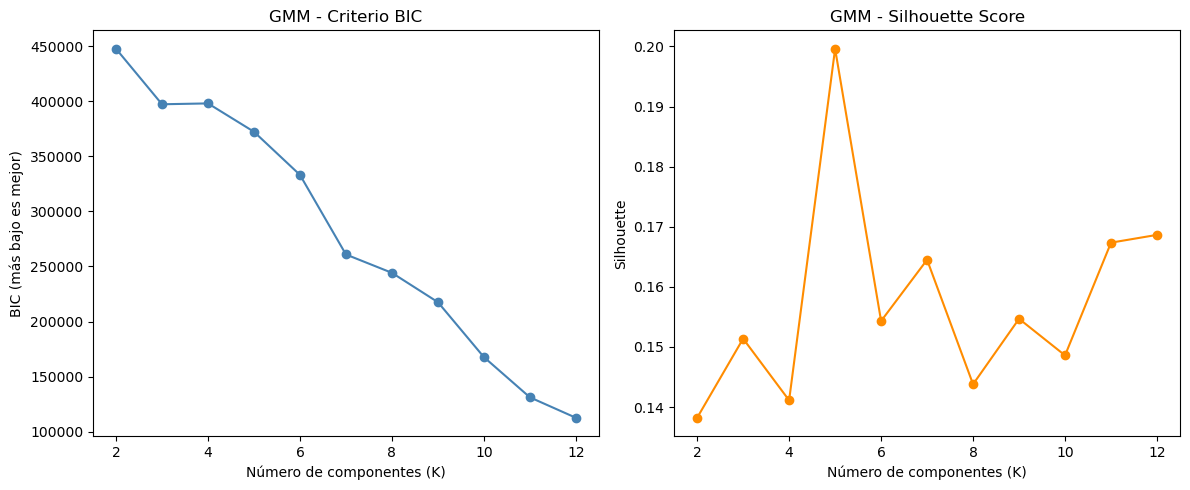

K óptimo GMM según BIC: 12
K óptimo GMM según silhouette: 5
Silueta final (GMM): 0.169
Davies–Bouldin (GMM): 1.669


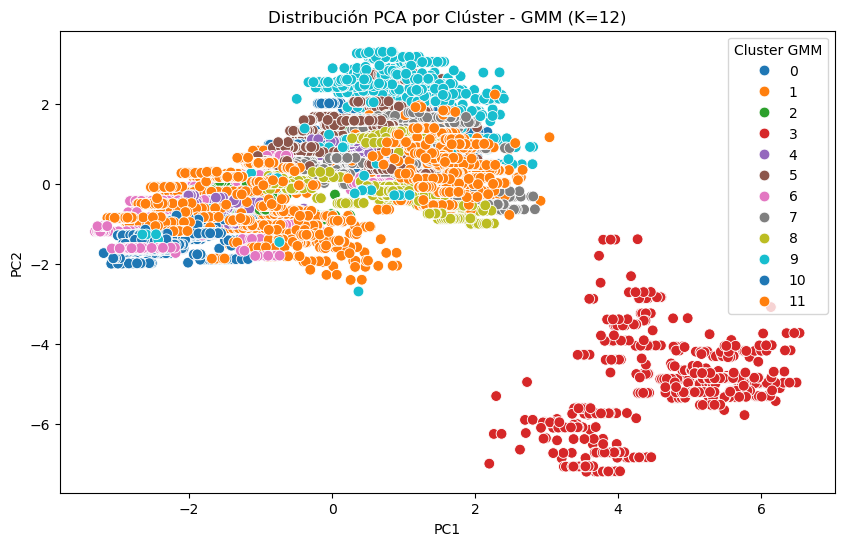

In [7]:
pca_gmm = PCA(n_components=10, random_state=42)
X_pca_gmm = pca_gmm.fit_transform(df_scaled)

# Número óptimo de componentes (K) con BIC y silhouette
K_range = range(2, 13)
bics_gmm = []
silhouette_vals_gmm = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_pca_gmm)
    labels_k = gmm.predict(X_pca_gmm)
    bics_gmm.append(gmm.bic(X_pca_gmm))
    silhouette_vals_gmm.append(silhouette_score(X_pca_gmm, labels_k))

# Gráficos BIC y Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K_range, bics_gmm, 'o-', color='steelblue')
ax[0].set_title("GMM - Criterio BIC")
ax[0].set_xlabel("Número de componentes (K)")
ax[0].set_ylabel("BIC (más bajo es mejor)")

ax[1].plot(K_range, silhouette_vals_gmm, 'o-', color='darkorange')
ax[1].set_title("GMM - Silhouette Score")
ax[1].set_xlabel("Número de componentes (K)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

# Mejor K
k_optimo_gmm_bic = K_range[np.argmin(bics_gmm)]
k_optimo_gmm_sil = K_range[np.argmax(silhouette_vals_gmm)]
print(f"K óptimo GMM según BIC: {k_optimo_gmm_bic}")
print(f"K óptimo GMM según silhouette: {k_optimo_gmm_sil}")
k_optimo_gmm = k_optimo_gmm_bic  # decisión: nos quedamos con el de BIC

# Entrenamiento
gmm_final = GaussianMixture(n_components=k_optimo_gmm, covariance_type='full', random_state=42)
gmm_final.fit(X_pca_gmm)
labels_gmm = gmm_final.predict(X_pca_gmm)
probas_gmm = gmm_final.predict_proba(X_pca_gmm)

# Evaluación
silhouette_gmm = silhouette_score(X_pca_gmm, labels_gmm)
db_gmm = davies_bouldin_score(X_pca_gmm, labels_gmm)
print(f"Silueta final (GMM): {silhouette_gmm:.3f}")
print(f"Davies–Bouldin (GMM): {db_gmm:.3f}")

# PCA con colores por cluster
pca_df['Cluster_GMM'] = labels_gmm
plt.figure(figsize=(10, 6))
sns.scatterplot( data=pca_df, x='PC1', y='PC2', hue='Cluster_GMM', palette='tab10', s=60)
plt.title(f"Distribución PCA por Clúster - GMM (K={k_optimo_gmm})")
plt.legend(title="Cluster GMM")
plt.show()

df_cluster_ready['Cluster_GMM'] = labels_gmm

El BIC disminuye de forma clara hasta K=12, mientras que la silueta alcanza su máximo en K=5

Dado que el objetivo es disponer de un modelo con:
- buena calidad de ajuste,
- un número de clústeres todavía manejable para la toma de decisiones,

se opta por **K = 12** siguiendo el criterio de BIC.

#### Resultados y comparación

Con K=12, GMM obtiene:

- Silhouette ≈ 0.17, mejor que K-Means (0.14) pero inferior a HDBSCAN (0.45).
- Davies–Bouldin ≈ 1.67, también mejor que K-Means (2.01), aunque peor que HDBSCAN (0.91).

En la proyección PCA (PC1–PC2) se observan:

- varios grupos elípticos bien diferenciados
- menos solapamiento visual que con K-Means.

## 3. Comparativa métricas de modelos

Comparativa de rendimiento de modelos de clustering:


,Modelo,Clusters,Silhouette,Davies–Bouldin
0,HDBSCAN,76,0.449,0.909
1,GMM,12,0.169,1.669
2,K-Means,8,0.137,2.006


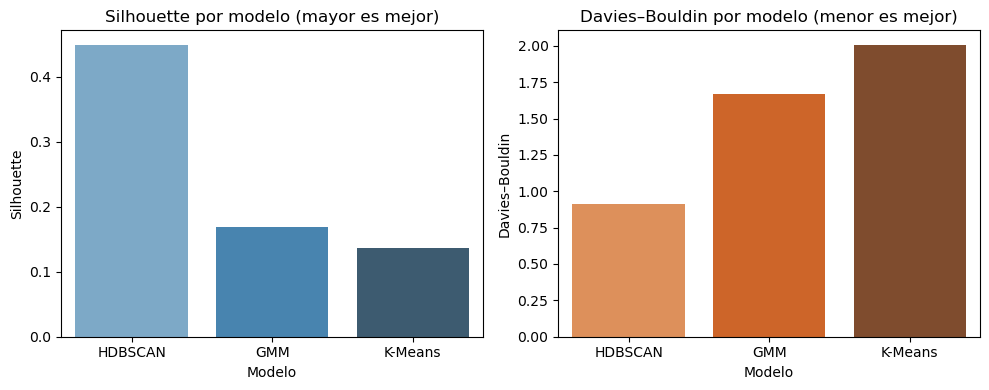

Modelo óptimo según Silhouette: HDBSCAN


In [8]:
comparacion = pd.DataFrame([
    {
        "Modelo": "K-Means",
        "Clusters": k_optimo,
        "Silhouette": silhouette_avg,
        "Davies–Bouldin": db_score
    },
    {
        "Modelo": "HDBSCAN",
        "Clusters": n_clusters,
        "Silhouette": sil_hdb if n_clusters > 1 else np.nan,
        "Davies–Bouldin": db_hdb if n_clusters > 1 else np.nan
    },
    {
        "Modelo": "GMM",
        "Clusters": k_optimo_gmm,
        "Silhouette": silhouette_gmm,
        "Davies–Bouldin": db_gmm
    }
])


comparacion["Silhouette"] = comparacion["Silhouette"].round(3)
comparacion["Davies–Bouldin"] = comparacion["Davies–Bouldin"].round(3)
comparacion = comparacion.sort_values(by="Silhouette", ascending=False).reset_index(drop=True)
print("Comparativa de rendimiento de modelos de clustering:")
display(comparacion)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    data=comparacion,
    x="Modelo",
    y="Silhouette",
    hue="Modelo",
    palette="Blues_d",
    legend=False,
    ax=ax[0]
)
ax[0].set_title("Silhouette por modelo (mayor es mejor)")
ax[0].set_ylabel("Silhouette")

sns.barplot(
    data=comparacion,
    x="Modelo",
    y="Davies–Bouldin",
    hue="Modelo",
    palette="Oranges_d",
    legend=False,
    ax=ax[1]
)
ax[1].set_title("Davies–Bouldin por modelo (menor es mejor)")
ax[1].set_ylabel("Davies–Bouldin")

plt.tight_layout()
plt.show()

# Selección automática
modelo_optimo = comparacion.loc[comparacion["Silhouette"].idxmax(), "Modelo"]
print(f"Modelo óptimo según Silhouette: {modelo_optimo}")


### 3.1. Elección final y justificación.

- **HDBSCAN** ofrece la mejor calidad de clústeres, pero a costa de **76 grupos**, poco operativo para un dashboard de apoyo a decisiones.
- **K-Means (K=8)** es simple pero genera clústeres muy rígidos y con peor separación.
- **GMM (K=12)** proporciona un **compromiso razonable** entre calidad (mejora a K-Means en silueta y Davies–Bouldin) e **interpretabilidad**, por lo que se elegirá como **modelo principal de segmentación** para integrar en Power BI.

## 4. Interpretación de Clusters

Primero se van a valorar los cluster GGM que se han encontrado en el modelado anterior para tratar de encontrar una interpretación del tipo de pasajeros.

Durante este paso, vamos a recodificar las variables a su estado original, buscar la moda en las variables categoricas y medias en el resto.

### 4.1. Evaluación clústeres por Tipo de viaje.

,Cluster_GMM,Pasajeros_medios,Duración más frecuente,Alojamiento más frecuente,Organización más frecuente,Vía de acceso más frecuente
1,1,"49,894",De 4 a 7 noches,De mercado,Con paquete turístico,Aeropuerto
6,6,"31,259",De 4 a 7 noches,De mercado,Con paquete turístico,Aeropuerto
5,5,"27,494",De 4 a 7 noches,De mercado,Sin paquete turístico,Aeropuerto
0,0,"16,655",De 4 a 7 noches,De mercado,Sin paquete turístico,Aeropuerto
10,10,"16,098",De 4 a 7 noches,De mercado,Con paquete turístico,Aeropuerto
7,7,"13,986",De 4 a 7 noches,De mercado,Sin paquete turístico,Aeropuerto
8,8,"13,963",De 4 a 7 noches,Hotelero,Sin paquete turístico,Aeropuerto
2,2,"13,609",De 4 a 7 noches,De mercado,Sin paquete turístico,Aeropuerto
4,4,"13,212",De 4 a 7 noches,Hotelero,Con paquete turístico,Aeropuerto
11,11,"11,689",De 4 a 7 noches,De mercado,Sin paquete turístico,Aeropuerto


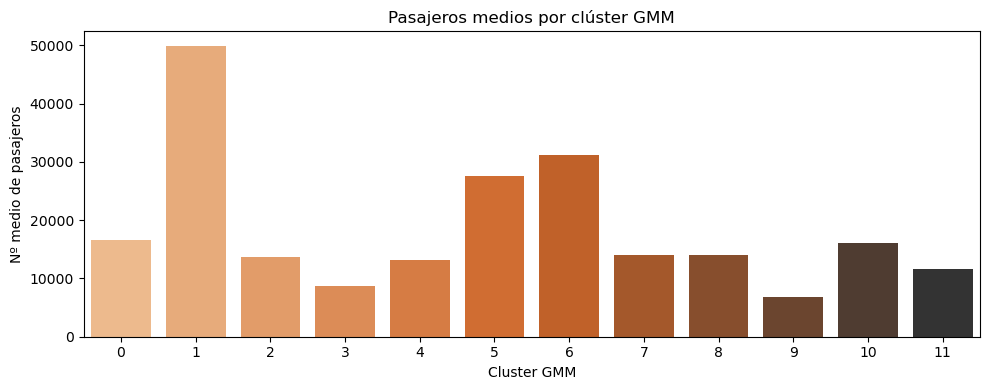

In [9]:
# Columnas one-hot
aloj_cols = [c for c in df_cluster_ready.columns if c.startswith("Tipo de alojamiento_")]
org_cols  = [c for c in df_cluster_ready.columns if c.startswith("Forma de organización del viaje_")]
via_cols  = [c for c in df_cluster_ready.columns if c.startswith("Vía de acceso_")]

mapa_duracion = {
    1: "1 noche",
    2: "De 2 a 3 noches",
    3: "De 4 a 7 noches",
    4: "De 8 a 15 noches",
    5: "Más de 15 noches"
}

def categoria_moda(df_sub, cols):
    """Devuelve la categoría más frecuente a partir de columnas one-hot."""
    if not cols:
        return np.nan
    sub = df_sub[cols]
    col_mas_freq = sub.mean().idxmax()
    return col_mas_freq.split("_", 1)[1]

def obtener_moda(cols, nombre_col_salida):
    """Agrupa por clúster y calcula la categoría modal."""
    return (
        df_cluster_ready.groupby("Cluster_GMM", observed=True)[cols]
        .apply(lambda g: categoria_moda(g, cols), include_groups=False)
        .reset_index(name=nombre_col_salida)
    )

# Pasajeros medios (deshaciendo el log)
perfiles_num = (
    df_cluster_ready.groupby("Cluster_GMM", observed=True)["Total_log"]
    .mean()
    .reset_index()
)
perfiles_num["Pasajeros_medios"] = np.expm1(perfiles_num["Total_log"])

# Duración modal
duracion_moda = (
    df_cluster_ready.groupby("Cluster_GMM", observed=True)["Duración codificada"]
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name="Duración_moda_cod")
)
duracion_moda["Duración más frecuente"] = duracion_moda["Duración_moda_cod"].map(mapa_duracion)
duracion_moda = duracion_moda.drop(columns="Duración_moda_cod")

# Modas categóricas
aloj_moda = obtener_moda(aloj_cols, "Alojamiento más frecuente")
org_moda  = obtener_moda(org_cols,  "Organización más frecuente")
via_moda  = obtener_moda(via_cols,  "Vía de acceso más frecuente")

# Tabla final de perfiles
perfiles_gmm = (
    perfiles_num[["Cluster_GMM", "Pasajeros_medios"]]
    .merge(duracion_moda, on="Cluster_GMM")
    .merge(aloj_moda, on="Cluster_GMM")
    .merge(org_moda, on="Cluster_GMM")
    .merge(via_moda, on="Cluster_GMM")
    .sort_values("Pasajeros_medios", ascending=False)
)

display(perfiles_gmm.style.format({"Pasajeros_medios": "{:,.0f}"}))

plt.figure(figsize=(10, 4))
sns.barplot(
    data=perfiles_gmm,
    x="Cluster_GMM",
    y="Pasajeros_medios",
    hue="Cluster_GMM",
    palette="Oranges_d",
    legend=False,
)
plt.title("Pasajeros medios por clúster GMM")
plt.ylabel("Nº medio de pasajeros")
plt.xlabel("Cluster GMM")
plt.tight_layout()
plt.show()


Las conclusiones de los clusteres se resumen en:

* Las duraciones son casi idénticas entre clústeres.
* El tipo de alojamiento apenas varía (salvo 3 clústeres).
* La organización es mitad con paquete, mitad sin.
* La vía de acceso es prácticamente siempre aeropuerto.
* Los “pasajeros medios” sí cambian.

Estos grupos son muy similares entre sí, por lo que la diferenciacion de los grupos debe tener más relación con los elementos geográficos que se estudian a continuación.

### 4.2 Evaluacion Clústeres por geografía

Distribución de Clusters GMM por País:


Cluster_GMM,0,1,2,3,4,5,6,7,8,9,10,11
País de residencia,,,,,,,,,,,,
Alemania,0.289509,0.0,0.000000,0.000000,0.000000,0.0,0.643648,0.000000,0.000000,0.049137,0.000000,0.017707
Bélgica,0.000000,0.0,0.251273,0.000000,0.164686,0.0,0.000000,0.174873,0.059423,0.057725,0.285229,0.006791
Dinamarca,0.000000,0.0,0.216931,0.000000,0.134921,0.0,0.000000,0.092593,0.047619,0.018519,0.481481,0.007937
Estados Unidos de América,0.000000,0.0,0.000000,0.201818,0.000000,0.0,0.000000,0.280000,0.205455,0.001818,0.000000,0.310909
Finlandia,0.000000,0.0,0.167598,0.000000,0.094972,0.0,0.000000,0.000000,0.000000,0.011173,0.625698,0.100559
Francia,0.288040,0.0,0.052779,0.172375,0.049972,0.0,0.000000,0.157215,0.090960,0.028074,0.112296,0.048287
Irlanda,0.226277,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.309489,0.154745,0.029197,0.201460,0.078832
Italia,0.000000,0.0,0.180155,0.045742,0.136524,0.0,0.000000,0.268121,0.180155,0.050669,0.057002,0.081633
Noruega,0.000000,0.0,0.186709,0.000000,0.145570,0.0,0.000000,0.145570,0.041139,0.044304,0.430380,0.006329


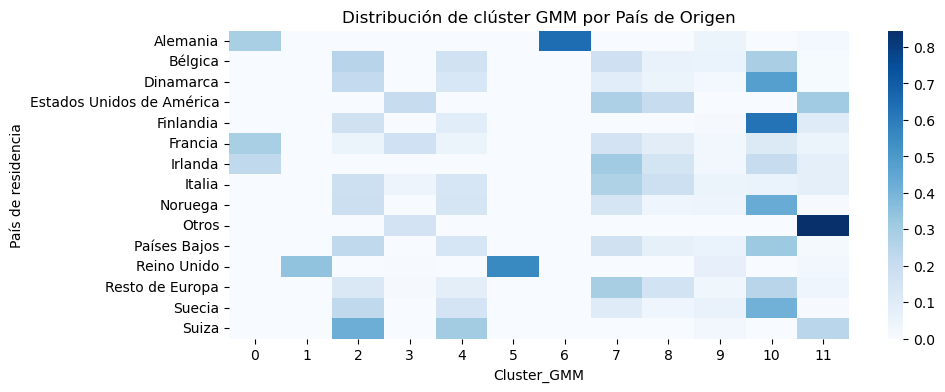

In [10]:
tab_pais = pd.crosstab(df_prep["País de residencia"], df_cluster_ready["Cluster_GMM"], normalize='index')
print("Distribución de Clusters GMM por País:")
display(tab_pais.head(10))
plt.figure(figsize=(10, 4))
sns.heatmap(tab_pais, cmap="Blues")
plt.title("Distribución de clúster GMM por País de Origen")
plt.show()

Cada país tiene una preferencia muy fuerte por 1–3 clústeres

* Alemania → Clusters 0 y 6
* Estados Unidos → Clusters 3, 7 y 11
* Finlandia/Noruega → Cluster 10 principalmente
* Italia → Clusters 2, 7 y 8
* Otros → Cluster 11 en un 84 %


Distribución de Clusters GMM por Comunidad Autónoma:


Cluster_GMM,0,1,2,3,4,5,6,7,8,9,10,11
Comunidad autónoma de destino,,,,,,,,,,,,
01 Andalucía,0.259459,0.079279,0.205405,0.046246,0.072673,0.203003,0.063664,0.004204,0.004204,0.055856,0.000000,0.006006
"04 Balears, Illes",0.217924,0.070029,0.228942,0.000979,0.190010,0.109696,0.090842,0.000000,0.000000,0.051910,0.000000,0.039667
05 Canarias,0.000000,0.101406,0.000000,0.000502,0.000000,0.102661,0.166165,0.103163,0.057480,0.005020,0.450301,0.013303
09 Cataluña,0.000000,0.046695,0.000000,0.140085,0.000000,0.111886,0.095512,0.293208,0.190722,0.020012,0.000000,0.101880
10 Comunitat Valenciana,0.000000,0.151754,0.000000,0.030780,0.000000,0.241947,0.000000,0.251969,0.070866,0.207588,0.000000,0.045097
"13 Madrid, Comunidad de",0.000000,0.000000,0.000000,0.003676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996324
Otras,0.000000,0.000000,0.000000,0.195122,0.000000,0.000000,0.000000,0.000000,0.000000,0.146341,0.000000,0.658537


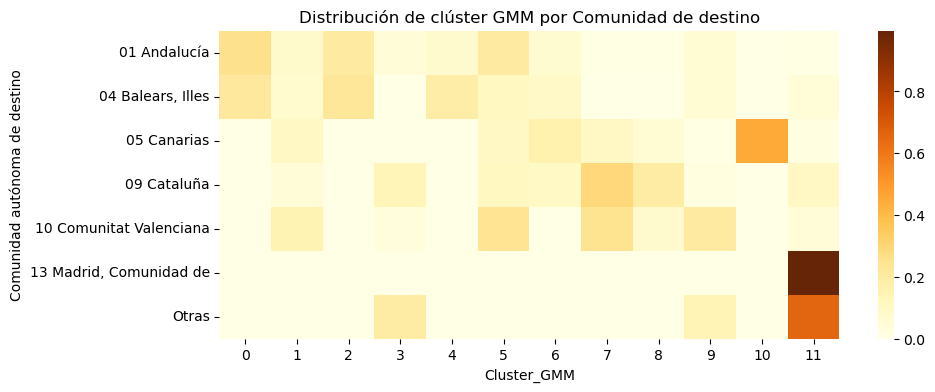

In [11]:
tab_comunidad = pd.crosstab(df_prep["Comunidad autónoma de destino"], df_cluster_ready["Cluster_GMM"], normalize='index')
print("\nDistribución de Clusters GMM por Comunidad Autónoma:")
display(tab_comunidad.head(10))
plt.figure(figsize=(10, 4))
sns.heatmap(tab_comunidad, cmap="YlOrBr")
plt.title("Distribución de clúster GMM por Comunidad de destino")
plt.show()

Cada comunidad autónoma también tiene patrones.

 * Canarias → 6 y 10
 * Cataluña → 7 y 8
 * Balears → 2 y 4
 * Madrid → 11 (casi exclusivamente)
 * Comunitat Valenciana → 5, 7, 9

### 4.3. Conclusiones sobre segmentación.

1. **Segmentacion de pasajeros - tipo de viaje**
   
En primer lugar se analizaron los perfiles medios de cada clúster a partir de:

- el número medio de pasajeros (revirtiendo la transformación logarítmica),
- la duración más frecuente del viaje,
- el tipo de alojamiento, forma de organización y vía de acceso más frecuentes.

Los resultados muestran que:

- **Las duraciones del viaje son muy similares entre clústeres**, concentradas en estancias cortas y medias (entre 2 y 7 noches).
- **El tipo de alojamiento dominante apenas cambia** entre grupos (predominan hoteles/apartamentos turísticos, con variaciones puntuales en 2–3 clústeres).
- **La forma de organización del viaje se reparte aproximadamente entre paquete y viaje por libre**, sin un patrón diferencial muy marcado por clúster.
- **La vía de acceso es mayoritariamente el aeropuerto** en prácticamente todos los grupos.

Es decir, los clústeres **no se diferencian tanto por la “forma de viajar”** (duración, alojamiento u organización), sino principalmente por el **volumen medio de pasajeros** y, como se observa a continuación, por la **combinación geográfica país de origen – comunidad de destino**.

2. **Segmentación por país de residencia y comunidad de destino**

La matriz de contingencia por país de residencia y clúster GMM muestra que:

- Cada país se concentra en **1–3 clústeres dominantes**.
- Por ejemplo:
    * Alemania → Clusters 0 y 6
    * Estados Unidos → Clusters 3, 7 y 11
    * Finlandia/Noruega → Cluster 10 principalmente
    * Italia → Clusters 2, 7 y 8
    * Otros → Cluster 11 en un 84 %

De forma análoga, la distribución por **comunidad autónoma de destino** indica que:

- Cada comunidad presenta **uno o varios clústeres predominantes**:
     * Canarias → 6 y 10
     * Cataluña → 7 y 8
     * Balears → 2 y 4
     * Madrid → 11 (casi exclusivamente)
     * Comunitat Valenciana → 5, 7, 9

3. **Conclusión general**

Estas evidencias sugieren que el modelo GMM está capturando principalmente **patrones de mercado geográficos**:

- combinaciones específicas de **país de origen y destino**,
- con diferencias de volumen y composición interna,
- pero con características de viaje relativamente homogéneas entre clústeres.

En otras palabras, los clústeres GMM segmentan a los turistas **más por “mercado origen–destino” que por “tipo de viaje”**, lo que encaja con el diseño del dataset (datos agregados por país, comunidad y características del viaje) y con el objetivo del TFG: disponer de una segmentación interpretable que pueda alimentar cuadros de mando en Power BI para analizar mercados turísticos por origen y destino.

### 5. Creación de tablas para Power BI

Una vez seleccionado el modelo GMM y analizados los clústeres, se generan varias tablas de salida en formato CSV. El objetivo es aproximarse a un modelo en estrella sencillo, donde el dashboard se centre en indicadores agregados y fácilmente interpretables para la toma de decisiones.

En la práctica, el modelo de Power BI se apoya en **dos tablas principales**, mientras que una tercera tabla se mantiene como recurso analítico para el TFG.

1. **`cluster_geografia_powerbi.csv` (tabla de hechos agregada Comunidad–País–Clúster)**  
   Tabla agregada por:
   - *Comunidad autónoma de destino*  
   - *País de residencia*  
   - *Cluster_GMM*  

   Para cada combinación se incluye:
   - el recuento de observaciones (*Recuento*),  
   - el total de registros por pareja Comunidad–País (*Total_CA_Pais*),  
   - y el *Porcentaje* que representa cada clúster dentro de esa pareja.

   Esta tabla es la base del dashboard: permite construir mapas y gráficos que muestran qué clústeres dominan en cada mercado de origen–destino y cómo se reparte la demanda entre segmentos.

2. **`dim_cluster_perfil_powerbi.csv` (dimensión de clúster GMM)**  
   Tabla pequeña (12 filas, una por clúster GMM) que resume, para cada segmento:
   - el número medio de pasajeros (*Pasajeros_medios*),  
   - la *Duración más frecuente*,  
   - el *Alojamiento más frecuente*,  
   - la *Organización más frecuente* del viaje,  
   - la *Vía de acceso más frecuente*,  
   - y un campo de texto `Perfil_GMM` con una descripción sintética del “viaje tipo”.

   En el modelo de Power BI se utiliza como **dimensión descriptiva**, enlazada por la clave `Cluster_GMM`. De este modo, el usuario puede interpretar rápidamente qué tipo de viajero hay detrás de cada clúster cuando explora los datos geográficos.

3. **`data_cluster_final.csv` (tabla analítica opcional)**  
   Esta tabla contiene todas las observaciones utilizadas en el modelo de clustering, con:
   - las variables preprocesadas,
   - las columnas one-hot,
   - y la asignación de `Cluster_GMM` a nivel de registro.

   No será cargada en el modelo de Power BI orientado a negocio, ya que no aporta valor directo al decisor.  
   Sin embargo, se mantiene dentro del TFG para trazabilidad y análisis.


In [12]:
# data_cluster_final.csv
cols_export = [
    c for c in df_cluster_ready.columns
    if c not in ["Cluster_KMeans", "Cluster_HDBSCAN"]  # nos quedamos solo con GMM
]

df_cluster_final = df_cluster_ready[cols_export].copy()

ruta_final = "data_cluster_final.csv"
df_cluster_final.to_csv(ruta_final, index=False, encoding="utf-8-sig")
print(f"Dataset final exportado correctamente a: {ruta_final}")

# cluster_geografia_powerbi.csv
df_geo = pd.concat(
    [
        df_prep[["Comunidad autónoma de destino", "País de residencia"]].reset_index(drop=True),
        df_cluster_ready[["Cluster_GMM"]].reset_index(drop=True),
    ],
    axis=1
)

cluster_geo = (
    df_geo
    .groupby(
        ["Comunidad autónoma de destino", "País de residencia", "Cluster_GMM"],
        observed=True
    )
    .size()
    .reset_index(name="Recuento")
)

totales = (
    cluster_geo
    .groupby(["Comunidad autónoma de destino", "País de residencia"], observed=True)["Recuento"]
    .sum()
    .reset_index(name="Total_CA_Pais")
)

cluster_geo = cluster_geo.merge(
    totales,
    on=["Comunidad autónoma de destino", "País de residencia"],
    how="left"
)

cluster_geo["Porcentaje"] = cluster_geo["Recuento"] / cluster_geo["Total_CA_Pais"]

ruta_geo = "cluster_geografia_powerbi.csv"
cluster_geo.to_csv(ruta_geo, index=False, encoding="utf-8-sig")
print(f"Exportado: {ruta_geo}")


# dim_cluster_perfil_powerbi.csv
dim_cluster = perfiles_gmm.copy()

# País dominante por clúster (mayor peso relativo dentro del clúster)
tab_pais_cluster = pd.crosstab(
    df_prep["País de residencia"],
    df_cluster_ready["Cluster_GMM"],
    normalize="columns"
)

pais_dom = (
    tab_pais_cluster
    .idxmax()
    .rename("Pais_dominante")
    .reset_index()
)

# Comunidad dominante por clúster
tab_ca_cluster = pd.crosstab(
    df_prep["Comunidad autónoma de destino"],
    df_cluster_ready["Cluster_GMM"],
    normalize="columns"
)

ca_dom = (
    tab_ca_cluster
    .idxmax()
    .rename("CA_dominante")
    .reset_index()
)

# Unimos país y comunidad dominantes
dim_cluster = dim_cluster.merge(pais_dom, on="Cluster_GMM", how="left")
dim_cluster = dim_cluster.merge(ca_dom, on="Cluster_GMM", how="left")

def crear_texto_perfil(row):
    return (
        f"Cluster {row['Cluster_GMM']}: mercado principal "
        f"{row['Pais_dominante']} hacia {row['CA_dominante']}. "
        f"Viaje típico de {row['Duración más frecuente']}, "
        f"alojamiento {row['Alojamiento más frecuente'].lower()}, "
        f"{row['Organización más frecuente'].lower()} "
        f"y acceso por {row['Vía de acceso más frecuente'].lower()}. "
        f"Pasajeros medios ≈ {int(row['Pasajeros_medios']):,} por combinación."
    )

dim_cluster["Perfil_GMM"] = dim_cluster.apply(crear_texto_perfil, axis=1)

ruta_perfil = "dim_cluster_perfil_powerbi.csv"
dim_cluster.to_csv(ruta_perfil, index=False, encoding="utf-8-sig")
print(f"Exportado: {ruta_perfil}")

Dataset final exportado correctamente a: data_cluster_final.csv
Exportado: cluster_geografia_powerbi.csv
Exportado: dim_cluster_perfil_powerbi.csv


## Bibliografía

* Chawla, A. (2024, 9 de julio). An algorithmic deep dive into HDBSCAN: The supercharged version of DBSCAN. Daily Dose of Data Science. Recuperado de https://www.dailydoseofds.com/hdbscan-the-supercharged-version-of-dbscan-an-algorithmic-deep-dive/
* Chawla, A. (2024, 23 de junio). HDBSCAN vs. DBSCAN. Daily Dose of Data Science. Recuperado de https://blog.dailydoseofds.com/p/hdbscan-vs-dbscan
* Chawla, A. (2023, 16 de agosto). Gaussian mixture models (GMMs). Daily Dose of Data Science. Recuperado de https://www.dailydoseofds.com/p/gaussian-mixture-models-gmms